Epoch 1/50


C:\Users\bibek\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_5', 'keras_tensor_9']. Received: the structure of inputs=('*', '*', '*')
  warnings.warn(


15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.3060 - loss: 1.6057 - val_accuracy: 0.5000 - val_loss: 1.0914
Epoch 2/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5921 - loss: 1.0314 - val_accuracy: 0.7167 - val_loss: 0.7266
Epoch 3/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6580 - loss: 0.7384 - val_accuracy: 0.9333 - val_loss: 0.4423
Epoch 4/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.7529 - loss: 0.5747 - val_accuracy: 0.8333 - val_loss: 0.5264
Epoch 5/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8147 - loss: 0.4565 - val_accuracy: 0.9333 - val_loss: 0.2290
Epoch 6/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8925 - loss: 0.2953 - val_accuracy: 0.8333 - val_loss: 0.3573
Epoch 7/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8948 - loss: 0.2458 - val_accuracy: 0.8833 - val_loss: 0.3191
Epoch 8/50
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9448 - loss: 0.1602 - val_accuracy: 0.9000 - val_loss: 0

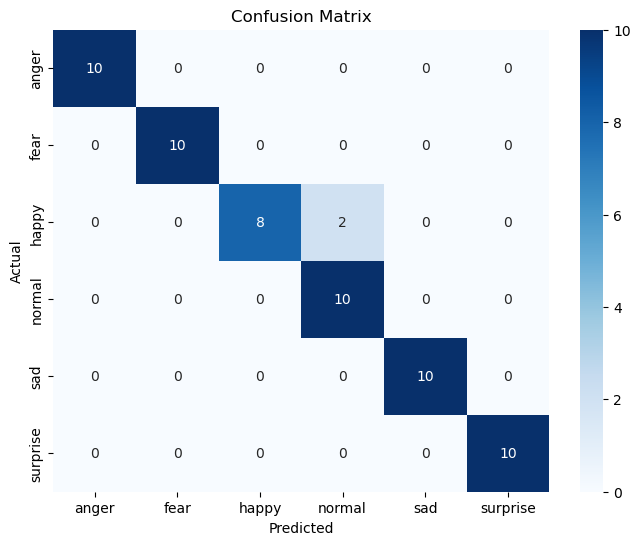

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        10
        fear       1.00      1.00      1.00        10
       happy       1.00      0.80      0.89        10
      normal       0.83      1.00      0.91        10
         sad       1.00      1.00      1.00        10
    surprise       1.00      1.00      1.00        10

    accuracy                           0.97        60
   macro avg       0.97      0.97      0.97        60
weighted avg       0.97      0.97      0.97        60



In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Load Extracted Features from Excel Files
path_thermal = "C:\\Users\\bibek\\Downloads\\PROJECT2\\thermalrefined.xlsx"
path_digital = "C:\\Users\\bibek\\Downloads\\PROJECT2\\digitfile_refined.xlsx"
path_eeg = "C:\\Users\\bibek\\Downloads\\PROJECT2\\EEGrefined.xlsx"

df_thermal = pd.read_excel(path_thermal)
df_digital = pd.read_excel(path_digital)
df_eeg = pd.read_excel(path_eeg)

# 2️⃣ Separate Labels and Features
y_labels = df_eeg.iloc[:, 0]  # Assuming first column is the emotion label

X_thermal = df_thermal.iloc[:, 1:].values  # Excluding label column
X_digital = df_digital.iloc[:, 1:].values  # Excluding label column
X_eeg = df_eeg.iloc[:, 1:].values  # Excluding label column

# 3️⃣ Encode Labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_labels)  # Convert emotions to numbers (0-5)

# 4️⃣ Convert Data to Correct Data Type (Fixing ValueError)
X_thermal = np.array(X_thermal, dtype=np.float32)
X_digital = np.array(X_digital, dtype=np.float32)
X_eeg = np.array(X_eeg, dtype=np.float32)
y = np.array(y, dtype=np.int32)

# 5️⃣ Normalize Features
scaler = StandardScaler()
X_thermal = scaler.fit_transform(X_thermal)
X_digital = scaler.fit_transform(X_digital)
X_eeg = scaler.fit_transform(X_eeg)

# 6️⃣ Reshape EEG Features for CNN Input
X_eeg = X_eeg.reshape((X_eeg.shape[0], X_eeg.shape[1], 1))  # Reshape for Conv1D

# 7️⃣ Train-Test Split
X_train_eeg, X_test_eeg, X_train_digital, X_test_digital, X_train_thermal, X_test_thermal, y_train, y_test = train_test_split(
    X_eeg, X_digital, X_thermal, y, test_size=0.2, random_state=42, stratify=y
)

# 8️⃣ Define Deep Learning Model (VGG + CNN)

# EEG Feature Extractor (1D CNN)
input_eeg = Input(shape=(X_train_eeg.shape[1], 1))
x1 = Conv1D(64, kernel_size=3, activation="relu")(input_eeg)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = Flatten()(x1)
x1 = Dense(128, activation="relu")(x1)

# Digital Feature Extractor (VGG16)
input_digital = Input(shape=(X_train_digital.shape[1],))
vgg_digital = Dense(512, activation="relu")(input_digital)
vgg_digital = Dense(256, activation="relu")(vgg_digital)
vgg_digital = Dense(128, activation="relu")(vgg_digital)

# Thermal Feature Extractor (VGG16)
input_thermal = Input(shape=(X_train_thermal.shape[1],))
vgg_thermal = Dense(512, activation="relu")(input_thermal)
vgg_thermal = Dense(256, activation="relu")(vgg_thermal)
vgg_thermal = Dense(128, activation="relu")(vgg_thermal)

# Fusion Layer
merged = Concatenate()([x1, vgg_digital, vgg_thermal])
merged = Dense(128, activation="relu")(merged)
merged = Dropout(0.4)(merged)
merged = Dense(64, activation="relu")(merged)

# Output Layer
output = Dense(6, activation="softmax")(merged)  # 6 emotions classification

# Create Model
model = Model(inputs=[input_eeg, input_digital, input_thermal], outputs=output)
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# 9️⃣ Train Model
history = model.fit(
    [X_train_eeg, X_train_digital, X_train_thermal], y_train,
    validation_data=([X_test_eeg, X_test_digital, X_test_thermal], y_test),
    epochs=50, batch_size=16, verbose=1
)

# 🔟 Evaluate Model
test_loss, test_accuracy = model.evaluate([X_test_eeg, X_test_digital, X_test_thermal], y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 🔹 Confusion Matrix
y_pred = np.argmax(model.predict([X_test_eeg, X_test_digital, X_test_thermal]), axis=1)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# 🔹 Classification Report
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


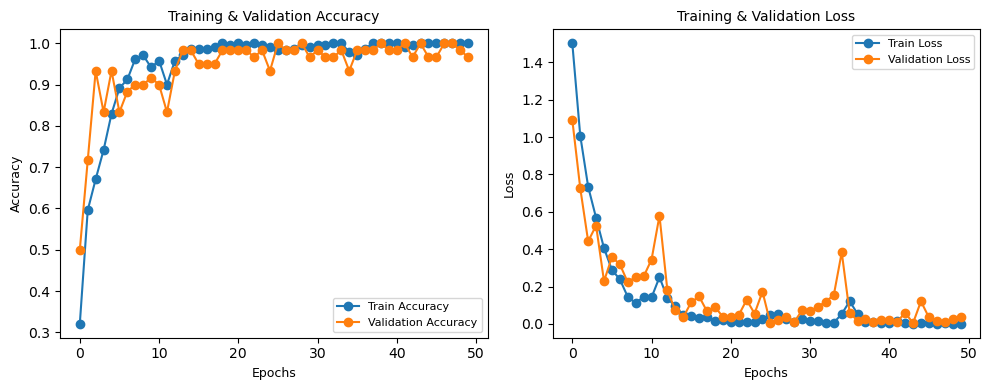

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


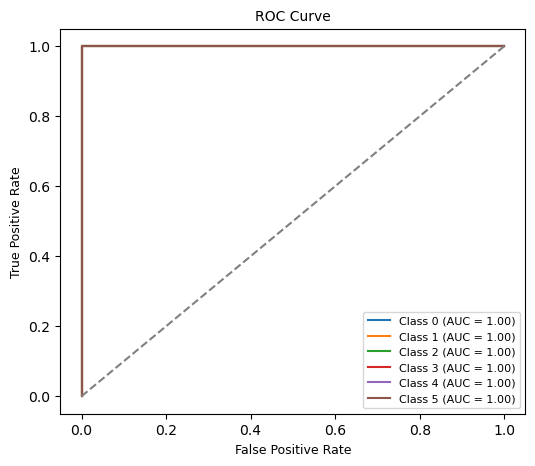

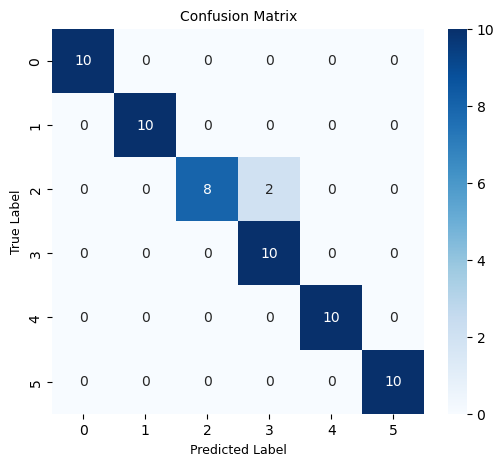

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix, roc_curve, auc

# 🔹 Training & Validation Accuracy & Loss Graphs
plt.figure(figsize=(10, 4))  # Small figure size

# Training & Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title("Training & Validation Accuracy", fontsize=10)
plt.xlabel("Epochs", fontsize=9)
plt.ylabel("Accuracy", fontsize=9)
plt.legend(fontsize=8)

# Training & Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title("Training & Validation Loss", fontsize=10)
plt.xlabel("Epochs", fontsize=9)
plt.ylabel("Loss", fontsize=9)
plt.legend(fontsize=8)

plt.tight_layout()
plt.show()

# 🔹 ROC Curve for Multiclass Classification
y_prob = model.predict([X_test_eeg, X_test_digital, X_test_thermal])  # Get predicted probabilities
y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=6)  # One-hot encode labels

plt.figure(figsize=(6, 5))  # Small figure size

for i in range(6):  
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])  # Compute FPR & TPR
    roc_auc = auc(fpr, tpr)  # Compute AUC Score
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle="--", color="gray")  # Random classifier line
plt.xlabel("False Positive Rate", fontsize=9)
plt.ylabel("True Positive Rate", fontsize=9)
plt.title("ROC Curve", fontsize=10)
plt.legend(fontsize=8)
plt.show()

# 🔹 Confusion Matrix
y_pred_classes = np.argmax(y_prob, axis=1)  # Convert probabilities to class labels
cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize=(6, 5))  # Small figure size
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(6), yticklabels=range(6))

plt.xlabel("Predicted Label", fontsize=9)
plt.ylabel("True Label", fontsize=9)
plt.title("Confusion Matrix", fontsize=10)
plt.show()
